In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
print (openai.api_key[-4:])
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

lX4n


## Define models ##

In [2]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    'LLMTime GPT-3': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

## Running LLMTime and Visualizing Results ##

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'text-davinci-003', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


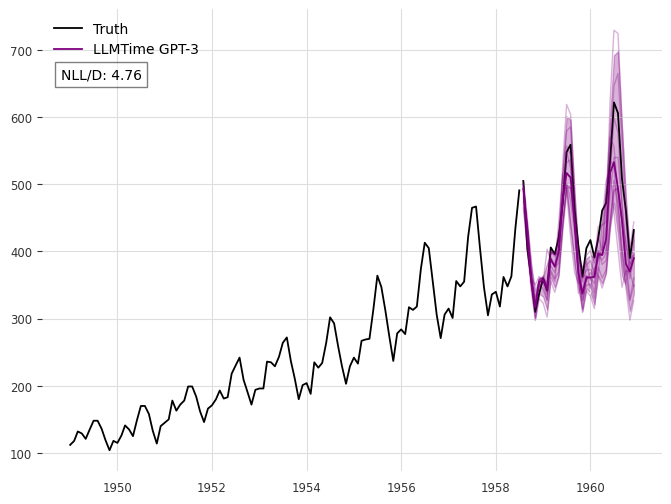

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.67s/it]


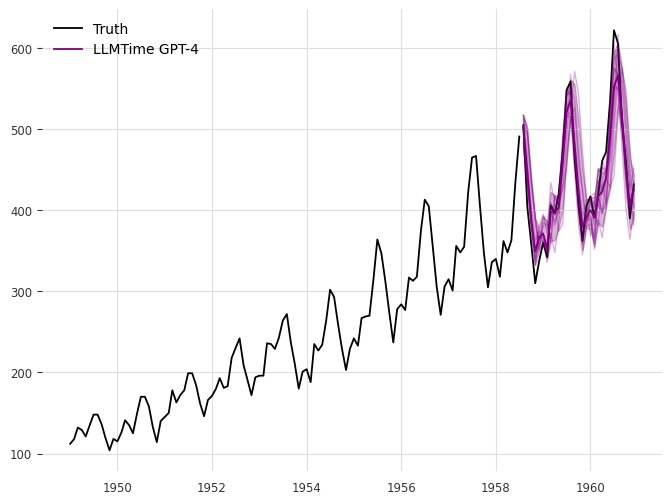

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'text-davinci-003', 'temp': 0.7, 'settings': SerializerSettings(base=10, prec=0, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=False, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


Found invalid prediction
Found invalid prediction
Got 8 properly formatted samples


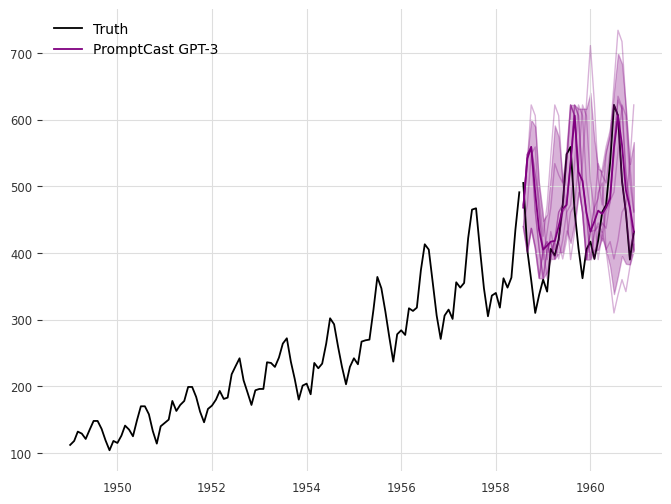

Train length: 86, Val length: 29


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]

/home/dbm/llmtime/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dbm/llmtime/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dbm/llmtime/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dbm/llmtime/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dbm/ll

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
 with NLL 3.747898


/home/dbm/llmtime/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dbm/llmtime/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dbm/llmtime/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


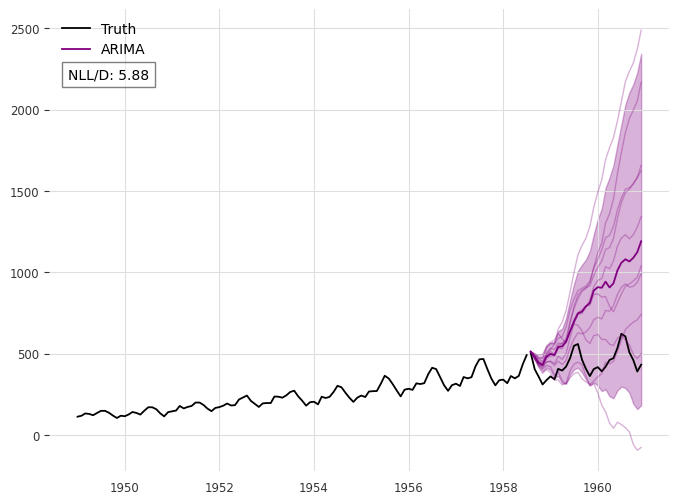

In [3]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)